In [69]:
import numpy as np
from pathlib import Path

from elucid.geometry import frame
from pyhipp.io import h5
from matplotlib import pyplot as plt
from scipy.spatial import KDTree

In [ ]:
root_dir = Path('../data/ELUCID-DMOL0500N3072/') 
root_filename = root_dir / 'simulation.hdf5'

## The mask file for the reconstructed volume

The following codes load the mask file that tells whether or not a 
location (in simulation coordinates) is within the reconstructed volume.

The mask is given as a Boolean array shaped `(n_grids, n_grids, n_grids)`, where
`n_grids = 500` is the number of grids along each dimension of the simulation 
volume. A value of `True` indicates that the corresponding grid 
is within the reconstructed volume.

In [54]:
mask_filename = root_dir / 'supplementary/reconstruction_pipeline/masks.hdf5'
mask = h5.File.load_from(mask_filename, 'reconstructed_volume_safe')
mask.shape, mask.dtype

((500, 500, 500), dtype('bool'))

In [55]:
# e.g. tell whether grid indexed (100, 200, 300), i.e. (x, y, z) = (100, 200, 300) Mpc/h, 
# is within the reconstructed volume
mask[100, 200, 300]

np.False_

For an arbitrary spatial location (x, y, z), you can identify its nearest grid 
and find whether that location is within the reconstructed volume:

In [56]:
n_grids = mask.shape[0]
l_grid = 500 / n_grids                      # grid spacing in Mpc/h

X = np.array([                              # take two positions for example
    [332.63, 318.91, 63.53],                # 1. simulated Coma (Abell 1656)
    (0., 0., 0.)                            # 2. position of box origin
])

grid_indices = (X / l_grid + 0.5).astype(int)
mask[tuple(grid_indices.T)]                 # whether they are in reconstructed volume

array([ True, False])

As a demonstration, we take a slice of the simulation box and 
plot the mask over it.

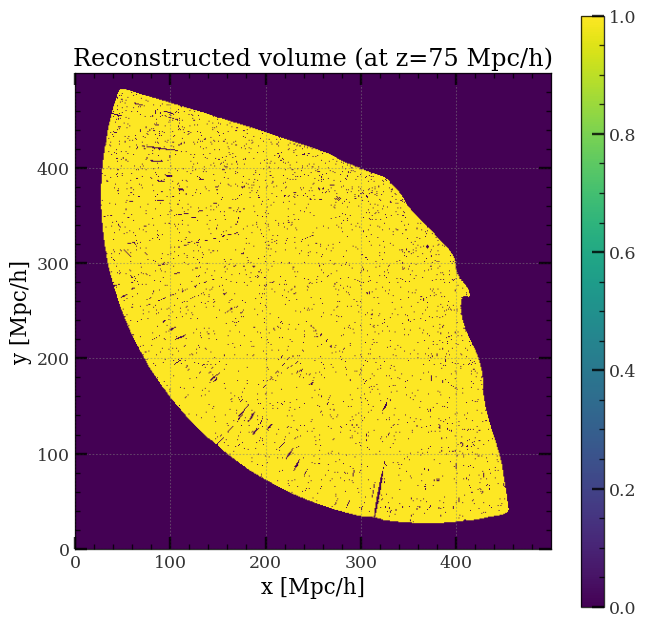

In [65]:
sliced_mask = mask[:, :, 75]

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(sliced_mask.T, origin='lower', vmin=0, vmax=1)

ax.set_xlabel('x [Mpc/h]')
ax.set_ylabel('y [Mpc/h]')
ax.set_title('Reconstructed volume (at z=75 Mpc/h)')
ax.set_aspect('equal')

plt.colorbar(im, ax=ax, aspect=25, location='right')
plt.show()

## Coordinate Systems

For the details of how to convert between the J2k observation coordinates and the simulation coordinates (i.e. $x \in [0, L)^3$, where L=500 Mpc/h), see 
Data Specification in the README of this repository.

Below are examples.

In [21]:
frame = frame.SimFrameSdssL500()

Here are the simulation coordinates (in $h^{-1}{\rm Mpc}$) of some known 
galaxy clusters

In [22]:
x_sims = np.array([
    [332.63, 318.91, 63.53],       # Coma (Abell 1656)
    [321.13, 335.49, 51.64],       # Leo (Abell 1367)
    [254.91 , 221.74 , 44.49],     # Abell 1630
    [215.07, 198.16, 38.16],       # Abell 1564 
])

Find their J2K (Cartesian) coordinates:

In [23]:
x_j2ks = frame.pos_sim_to_j2k(x_sims)
x_j2ks

array([[ -61.19392336,  -16.18668416,   33.53      ],
       [ -59.69696983,    3.93558038,   21.64      ],
       [-182.74476988,  -42.79117644,   14.49      ],
       [-228.54563981,  -36.04415383,    8.16      ]])

Convert J2K Cartesian coordinates to RA, Dec (both in degree), redshift:

In [24]:
ras, decs, zs = frame.pos_j2k_to_ra_dec_z(x_j2ks)
for ra, dec, z in zip(ras, decs, zs):
    print(f"RA: {ra:.3f} deg, Dec: {dec:.3f} deg, z: {z:.5f}")

RA: 194.816 deg, Dec: 27.911 deg, z: 0.02401
RA: 176.228 deg, Dec: 19.886 deg, z: 0.02131
RA: 193.179 deg, Dec: 4.415 deg, z: 0.06359
RA: 188.962 deg, Dec: 2.020 deg, z: 0.07844


Convert them back to J2K coordinates:

In [25]:
x_j2ks = frame.pos_ra_dec_z_to_j2k(ras, decs, zs)
x_j2ks

array([[ -61.20606901,  -16.18989686,   33.53665497],
       [ -59.70329613,    3.93599745,   21.64229327],
       [-182.75836651,  -42.7943602 ,   14.49107809],
       [-228.55359101,  -36.04540782,    8.16028389]])

and then back to simulation coordinates:

In [26]:
x_sims = frame.pos_j2k_to_sim(x_j2ks)
x_sims

array([[332.62258287, 318.89985976,  63.53665497],
       [321.12482107, 335.48634285,  51.64229327],
       [254.90143704, 221.72896912,  44.49107809],
       [215.06460992, 198.15402161,  38.16028389]])

## Corrections for redshift-space distortions

To use the reconstructed fields and connect them with galaxies in real observations, 
it is recommended to correct the redshift-space distortions (RSD) caused by the peculiar
motion of observed galaxies.
With a correction for RSD, the real-space position of a galaxy is known, and then you may 
use our data to compute, e.g. the local overdensity in a 3-D aperture around that galaxy.
Without RSD correction, you may also use our data to compute the local overdensity, but
the aperture should be sufficiently large along the line of sight to average out 
the RSD effects.

The procedure to make a RSD correction, however, is not trivial. 
Kaiser effect can usually be corrected in a more straightforward manner. But the correction for the 
'Finger of God' (FoG) effect is more challenging, and
is not deterministic given the stochastic nature of the peculiar motion within 
galaxy groups (known as the Finger of God, FoG, effect). 

A simple way to correct the total RSD effect, which we recommend here, is to use
match any galaxy, say, observed at (RA, Dec, z_obs), to a galaxy in our SDSS sample 
that was corrected by us and was used to reconstruct the density field.
The real-space position can then be read from that matched galaxy
in our sample.
This method cancels any non-deterministic factors in the correction, and ensures that the
corrected position is consistent with our reconstructed density field.
This, however, cannot be used for galaxies that are not in our SDSS sample.

Here we provide a procedure to match an observed galaxy to our sample, and 
output its corrected position.

In [79]:
# Load our sample
recon_sample_filename = root_dir / 'supplementary/reconstruction_pipeline/galaxy_recon.hdf5'
recon_sample = h5.File.load_from(recon_sample_filename)

# Maximal distance tolerance in the matching
ra_tol = .1 / 3600.0                            # RA in degree
dec_tol = .1 / 3600.0                           # Dec in degree
z_tol = 1.0e-4                                  # redshift

# The function for the match
def correct_rsd(ra: np.ndarray, dec: np.ndarray, z_obs: np.ndarray):
    scale = (ra_tol, dec_tol, z_tol)
    x_recon = np.column_stack(recon_sample['ra', 'dec', 'z_obs']) / scale
    x_target = np.column_stack((ra, dec, z_obs)) / scale
    
    _, ids = KDTree(x_recon).query(x_target)
    x_sim_cor = recon_sample['x_sim_cor'][ids]
    distances = np.abs(x_recon[ids] - x_target)
    matched = (distances < 1.).all(1)

    return {
        'matched': matched,                         # whether each input galaxy is matched
        'ids': ids,                                 # indices of matched galaxies in our sample
        'x_sim_cor': x_sim_cor                      # RSD-corrected positions in the simulation frame
    }

In [80]:
# take a few galaxies as example
target_sample = np.array([
    [219.374741, -1.142057, 0.014051],
    [177.022387, 0.991332, 0.010324],
    [169.886334, 0.379001, 0.025390],
    [151.799395, 0.809070, 0.021247],
]) 
matched_out = correct_rsd(
    ra=target_sample[:, 0],
    dec=target_sample[:, 1],
    z_obs=target_sample[:, 2],
)
matched_out

{'matched': array([ True,  True,  True,  True]),
 'ids': array([ 769, 4479, 8507, 9444]),
 'x_sim_cor': array([[361.97656872, 331.00021049,  29.2062394 ],
        [345.25599785, 352.00765648,  30.5293928 ],
        [303.42462199, 333.26914847,  30.5029657 ],
        [307.43777417, 358.06630301,  30.8994226 ]])}